# 电影推荐实验

本实验用协同过滤技术分析用户对电影的评分数据，并基于这个数据建立一个推荐系统，根据用户输入的一部感兴趣的电影，为其推荐其他可能感题目的电影。此案实验中，我们使用的数据集是MovieLens的ml-100k————用户对电影的评分数据，包含用户数据、评分数据、电影数据。


本实验基于华为推荐系统实验部分改编，使用基于用户的协同过滤算法完成。

## 导入基本工具库
执行下面方框中的这段代码，可以导入本次实验中使用的Python开发基本工具

    numpy                数据分处理工具
    pandas               文件读取和数据处理工具
    scipy                一个科学计算库
    sklearn              一个开源的机器学习库
    seaborn              基于matplotlib的数据可视化库
    matplotlib           一个2D绘图法

In [2]:
# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
# 导入可视化所需的库
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

## 导入并展示样本数据
使用pandas库导入用户的个人信息

用户数据的字段描述如下：
* user_id：用户ID
* age：用户年龄
* sex：性别
* occupation：职业
* zip_code：邮编

评分数据的字段描述如下：
* user_id：用户ID
* movide_id：电影ID
* rating：评分
* unix_tiemstamp：评分时间

电影数据的字段描述如下：
* user_id：用户ID
* movie_title：电影名
* release_date：上映日期
* IMDb_URL：IMDb链接
* unknown、Action、Children......：影片类型

In [3]:
users = pd.read_csv('./ml-100k/u.user', sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'])
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
movies = pd.read_csv('./ml-100k/u.item', sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])


下面分别打印前5个用户信息、评分信息、电影信息

In [4]:
#用户信息
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
#评分信息
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
#电影信息
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 数据清洗

去除一些无效或不需要的信息，比如video_release_date、imdb_url等，并且处理缺失值。


In [7]:
# 检查列名并移除
if 'video_release_date' in movies.columns and 'IMDb_URL' in movies.columns:
    movies.drop(['video_release_date', 'IMDb_URL'], axis=1, inplace=True)
else:
    print("某些列不存在于 DataFrame 中。")

# 处理缺失值
users.ffill(inplace=True)
ratings.ffill(inplace=True)
movies.ffill(inplace=True)

In [8]:
# 将unix_timestamp转换为可读的日期格式
ratings['date'] = pd.to_datetime(ratings['unix_timestamp'], unit='s')
ratings.drop('unix_timestamp', axis=1, inplace=True)

将处理好的数据做好保存，以便后续实验改进等更多操作。

In [9]:
# 保存预处理后的数据
users.to_csv('preprocessed_users.csv', index=False)
ratings.to_csv('preprocessed_ratings.csv', index=False)
movies.to_csv('preprocessed_movies.csv', index=False)


## 基于用户的协同过滤算法

1. 创建用户-电影评分矩阵
2. 计算不同用户之间的相似度
3. 计算前n个相似的用户
4. 计算对待推荐物品
5. 对待推荐物品评分进行排序
6. 按照分数高低进行推荐

### 创建用户-电影评分矩阵

根据评分数据表(ratings),创建用户-电影评分矩阵 

In [10]:
# 1.创建评分矩阵，行为用户ID，列为电影ID
ratings_matrix = ratings.pivot_table(index=['user_id'], columns=['movie_id'], values='rating').fillna(0)


查看用户-电影评分矩阵，其中每一行代表每部电影来自所有用户的评分；每一列代表每个用户对所有电影的评分。

In [11]:
ratings_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


matplotlib绘图库在显示中文字符时，可能出现当前字体不支持这些字符的情况。所以需要指定一个支持中文的字体。

In [12]:
# Windows系统的字体路径
font_path = 'C:\\Windows\\Fonts\\msyh.ttc'
font_prop = FontProperties(fname=font_path)

# 设置matplotlib的字体属性
plt.rcParams['font.family'] = font_prop.get_name()


对用户—职业的可视化分析，可以发现职业为学生的用户最多，职业为医生、家务劳动者、律师等的用户较少

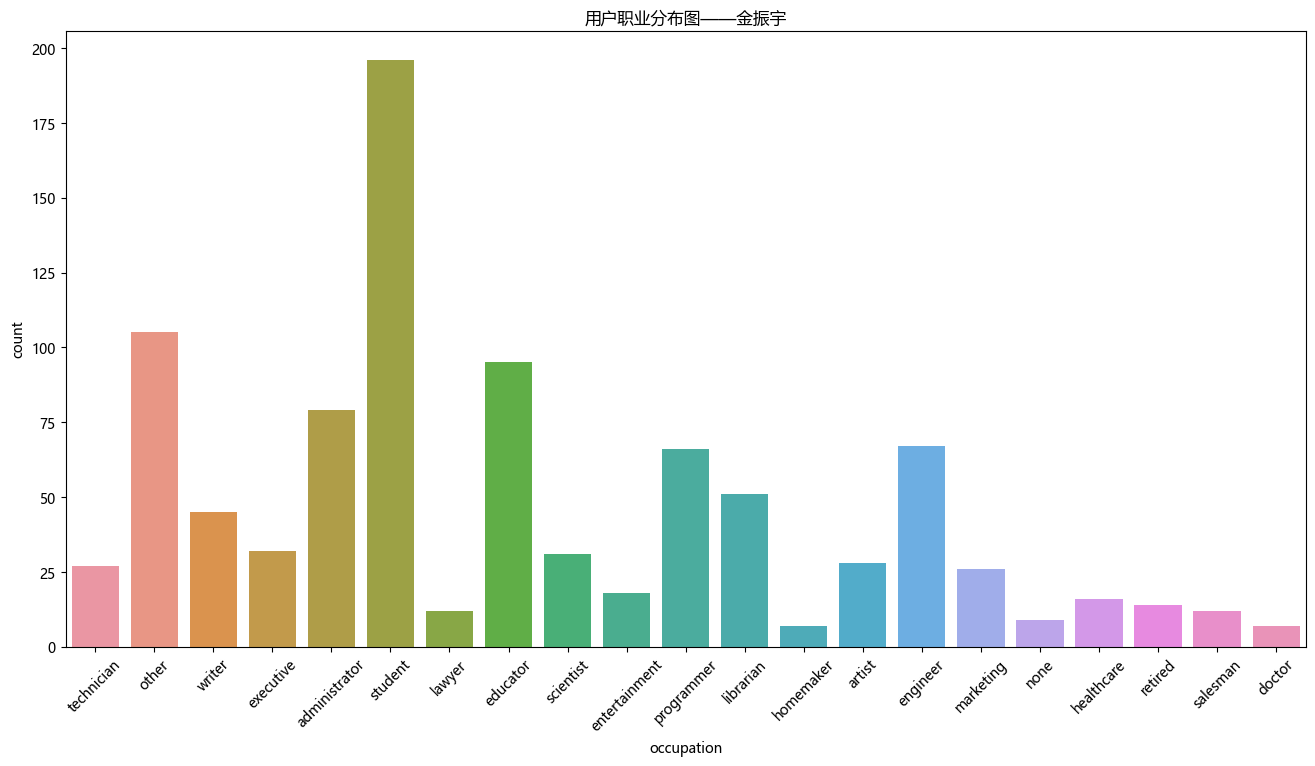

In [13]:
# 用户数据可视化
plt.figure(figsize=(16, 8))
sns.countplot(x='occupation', data=users)
plt.title('用户职业分布图——金振宇')
plt.xticks(rotation=45)
plt.show()

对电影评分的可视化分析，图中可以发现4分电影最多，1分电影最少。

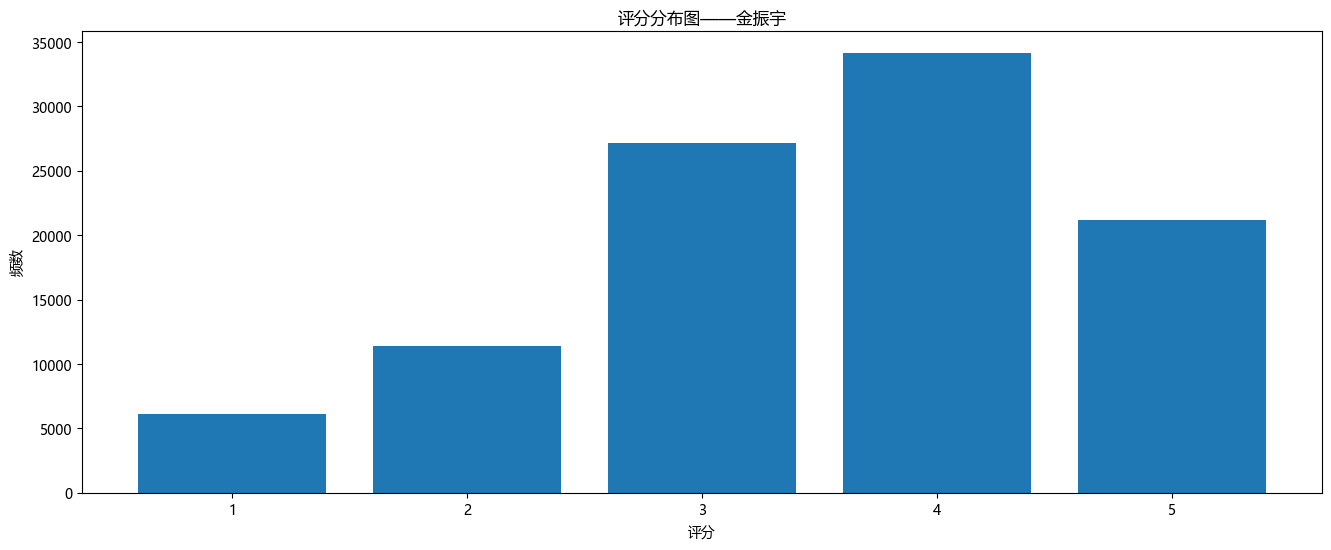

In [14]:
# 计算每个评分的频数
rating_counts = ratings['rating'].value_counts().sort_index()

# 设置图表大小
plt.figure(figsize=(16, 6))

# 绘制柱状图
plt.bar(rating_counts.index, rating_counts.values)

# 设置标题和轴标签
plt.title('评分分布图——金振宇')
plt.xlabel('评分')
plt.ylabel('频数')

# 设置x轴的刻度
plt.xticks(range(1, 6))

# 显示图表
plt.show()


### 计算不同用户之间的相似度

使用余弦相似度（Cosine Similarity）方法来计算用户之间的相似度。
这种方法通过测量两个用户评分向量之间的夹角的余弦值来评估它们的相似性。余弦值越接近1，表示两个用户的评分越相似。

In [15]:
# 2: 计算不同用户之间的相似度
# 使用余弦相似度计算用户之间的相似度
user_similarity = cosine_similarity(csr_matrix(ratings_matrix.values))
user_similarity_df = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

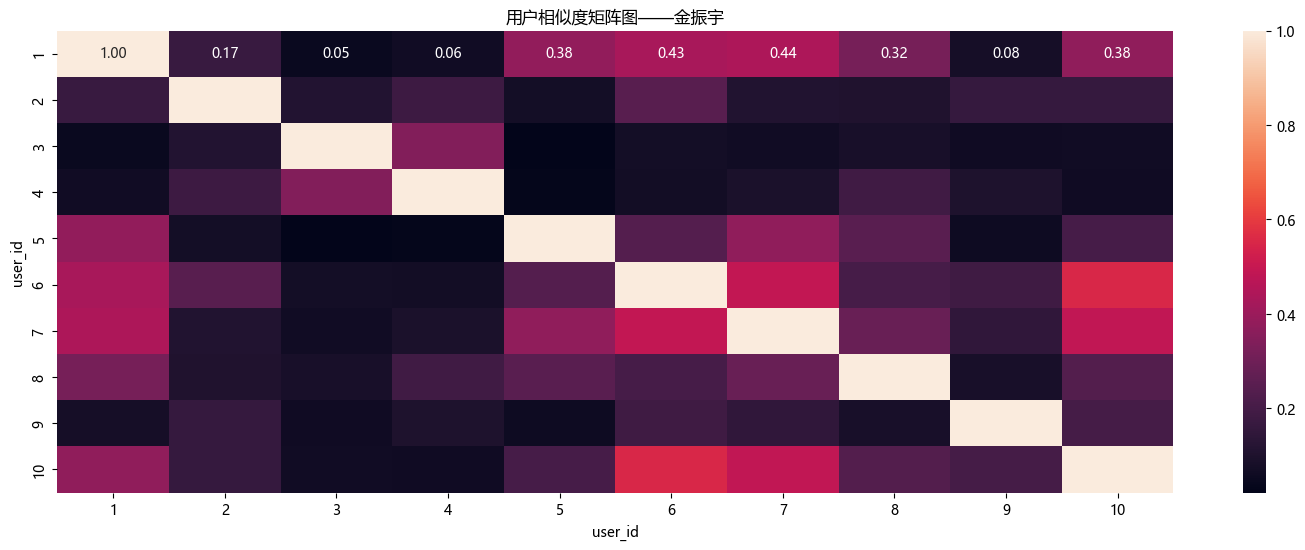

In [16]:
# 用户相似度矩阵可视化
plt.figure(figsize=(18, 6))
sns.heatmap(user_similarity_df.iloc[:10, :10], annot=True, fmt=".2f")
plt.title('用户相似度矩阵图——金振宇')
plt.show()

### 计算前n个相似的用户

通过对每个用户的相似度进行排序，选择与目标用户最相似的前n个用户。

In [17]:
# 3: 计算前n个相似的用户
# 定义一个函数来找到前n个相似的用户
def top_n_similar_users(user_id, n):
    user_similarities = user_similarity_df.loc[user_id]
    user_similarities = user_similarities.drop(user_id)
    top_users = user_similarities.sort_values(ascending=False).head(n).index
    return top_users

### 计算对待推荐物品的得分

对于每个待推荐的电影，计算其得分，将相似用户对该电影的评分乘以他们与目标用户的相似度，然后求和。这个得分反映了基于相似用户喜好的预测评分。

In [18]:
# 4: 计算对待推荐物品的得分
# 定义一个函数来计算对待推荐物品的得分
def calculate_score(similar_users, movie_id):
    score = sum(user_similarity_df.loc[user_id][similar_user] * ratings_matrix.loc[similar_user][movie_id] for similar_user in similar_users)
    return score

### 对待推荐物品评分进行排序

将所有待推荐电影的得分进行排序，以找出最有可能被目标用户喜欢的电影。涉及到一个排序操作，可以使用Python的sorted函数或类似方法来实现。

In [19]:
# 5: 对待推荐物品评分进行排序
# 定义一个函数来对待推荐物品评分进行排序
def recommend_movies(user_id, n):
    similar_users = top_n_similar_users(user_id, n)
    user_rated_movies = ratings_matrix.loc[user_id]
    not_rated_movies = user_rated_movies[user_rated_movies == 0].index.tolist()
    scores = {movie_id: calculate_score(similar_users, movie_id) for movie_id in not_rated_movies}
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_scores

### 按照分数高低进行推荐

最后，根据得分从高到低选择顶部的电影来进行推荐。这个步骤是推荐过程的最终输出，返回的列表中，包含了推荐的电影和它们的预测评分。

In [20]:
# 6: 按照分数高低进行推荐
# 定义一个函数按照分数高低进行推荐
def get_recommendations(user_id, n):
    recommended_movie_scores = recommend_movies(user_id, n)
    recommended_movies = [(movies[movies['movie_id'] == movie_id]['movie_title'].values[0], score) for movie_id, score in recommended_movie_scores]
    return recommended_movies

## 输出结果

为用户ID为1的用户推荐10部电影，结果如下

In [21]:
# 为用户ID为1的用户推荐10部电影
user_id = 1
n = 10
recommendations = get_recommendations(user_id, n)

with open('recommendations.txt', 'w', encoding='utf-8') as file:
    file.write("推荐给用户 {} 的电影及其预测评分:\n".format(user_id))
    for index, (movie, score) in enumerate(recommendations[:10], start=1):
        file.write("NO.{} 电影: {}, 预测评分: {:.2f}\n".format(index, movie, score))

print("推荐结果已写入到recommendations.txt中。")

推荐结果已写入到recommendations.txt中。


推荐电影的可视化，可以看见图中红色部分为分数大于19的7部电影，较为推荐的。

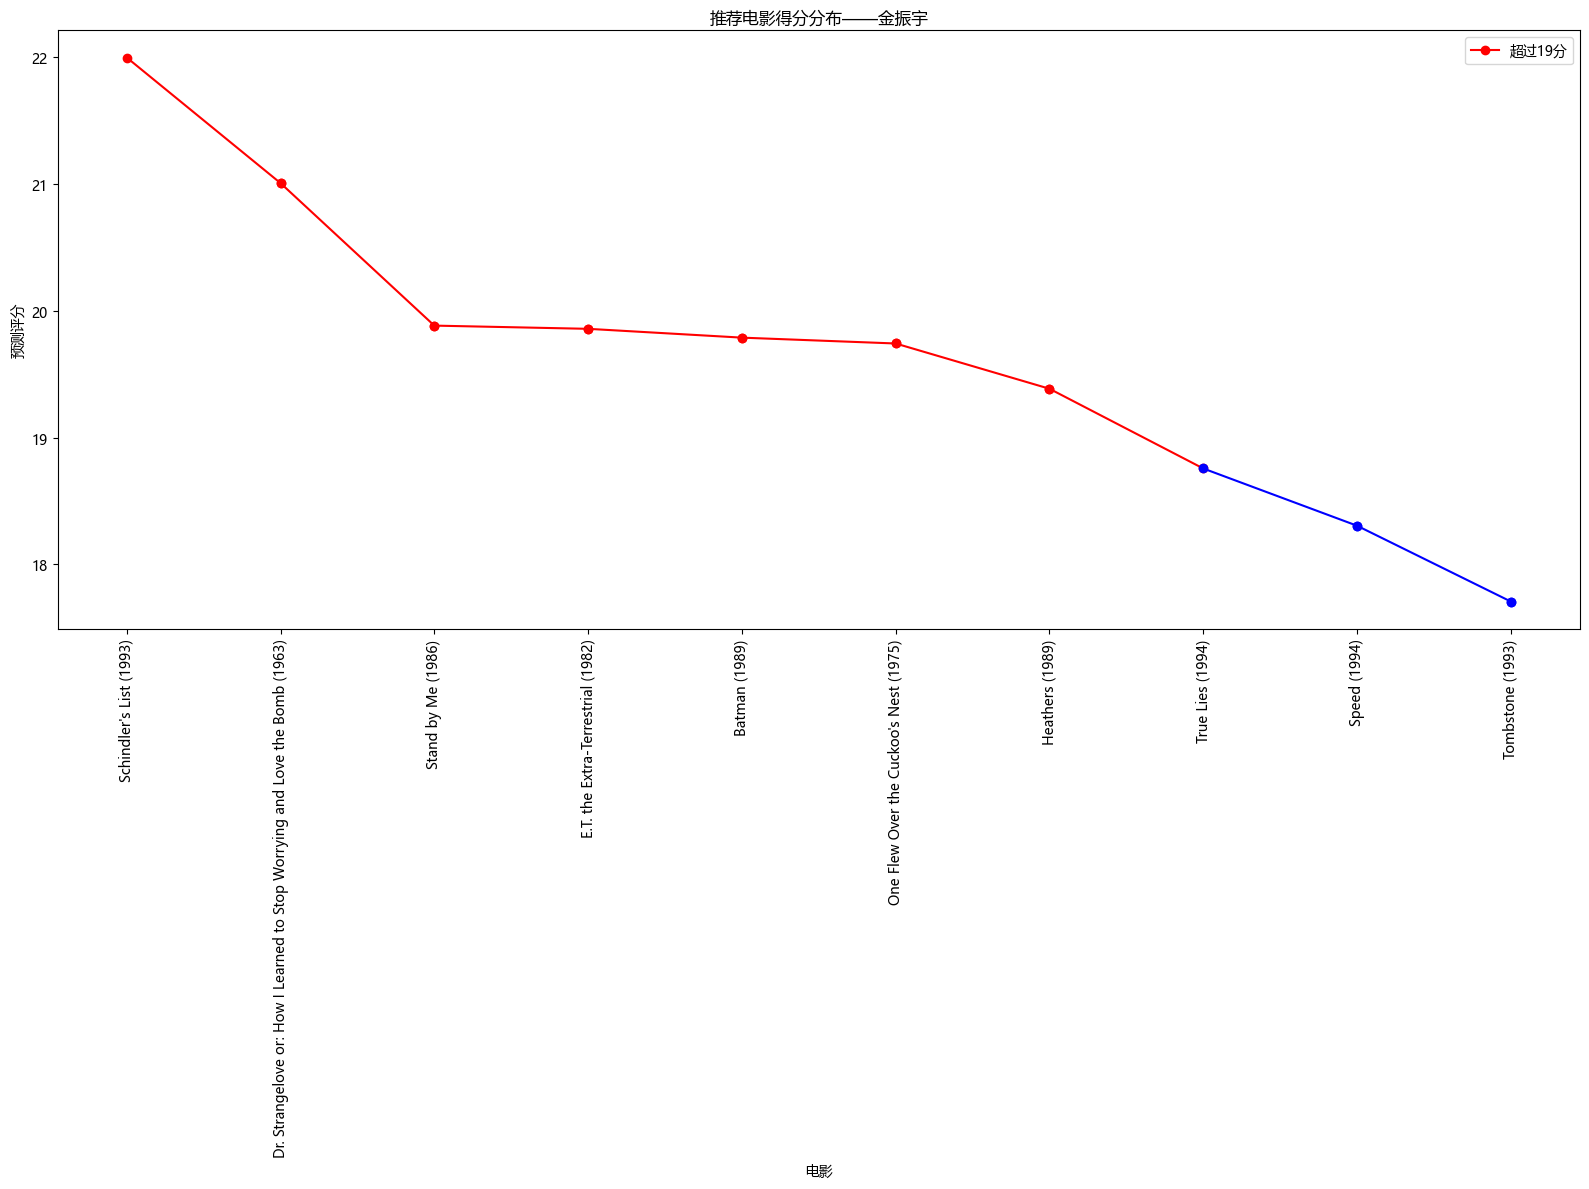

In [22]:
# 分离电影名称和预测评分
movies = [movie for movie, score in recommendations[:10]]
scores = [score for movie, score in recommendations[:10]]

# 创建折线图
plt.figure(figsize=(16, 12))
for i in range(len(movies)):
    if scores[i] > 19:
        plt.plot(movies[i:i+2], scores[i:i+2], 'ro-', label='超过19分' if i == 0 else "")
    else:
        plt.plot(movies[i:i+2], scores[i:i+2], 'bo-', label='未超过19分' if i == 0 else "")

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('推荐电影得分分布——金振宇')
plt.xlabel('电影')
plt.ylabel('预测评分')

# 设置x轴标签旋转，以便清晰显示
plt.xticks(rotation=90)

# 显示图表
plt.tight_layout()
plt.show()
